## **Setup**

In [1]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U
!pip install -q trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from transformers import set_seed
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model
from scipy.special import softmax, rel_entr

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft
from itertools import chain
from collections import Counter
import collections
import math
import numpy as np
from scipy.special import softmax
import pandas as pd

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [3]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **LoRA Setup**

In [5]:
# We freeze the models weights by setting the requires_grad attribute to False.

for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [6]:
# Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [7]:
# Setup LoRA Config using peft
config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 2359296 || all params: 126799104 || trainable%: 1.8606566809809635


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:336: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## **Data Loading and Tokenization**

In [8]:
data = []
prompts = []
responses = []
only_sherlock_data = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            # concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            # data.append(concatenated_lines)
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            # data.append({"Prompt": promptLine, "Response": responseLine})
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [9]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

In [10]:
tokenizer.pad_token = tokenizer.eos_token

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

In [12]:
from datasets import Dataset
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


## **Frequency Extraction**

### Colloquial English Frequency Extraction

In [13]:
# # Computing "typical" English token usage

# english_words_df = pd.read_csv('unigram_freq.csv')

# total_english_tokens = 0
# english_token_frequencies = collections.defaultdict(int)

# for _, row in english_words_df.iterrows():
#   word = row["word"]
#   freq = row["count"]
#   takens = []
#   try:
#     tokens = tokenizer(word)["input_ids"]
#     for token in tokens:
#       english_token_frequencies[token] += freq
#       total_english_tokens += freq
#   except:
#     print(f"Was unable to tokenize this word: {word}")

In [14]:
# for token in sorted(english_token_frequencies.keys(), key=lambda x: english_token_frequencies[x], reverse=True)[:10]:
#     print(f"{token}: {english_token_frequencies[token]}. Corresponding word: {tokenizer.decode(token)}")

### Sherlock Frequency Extraction

In [58]:
# Splitting data into training and testing data

train_data_only_sherlock_freq, val_data_only_sherlock_freq = train_test_split(only_sherlock_data, test_size=0.2, random_state=50)

train_data_only_sherlock_freq = [tokenizer(line) for line in train_data_only_sherlock_freq]
val_data_only_sherlock_freq = [tokenizer(line) for line in val_data_only_sherlock_freq]

In [59]:
# Computing number of tokens in training data

total_num_tokens = 0

for i in range(len(train_data_only_sherlock_freq)):
  total_num_tokens += len(train_data_only_sherlock_freq[i]['input_ids'])

In [60]:
input_ids = [d['input_ids'] for d in train_data_only_sherlock_freq]
flattened_tokens = list(chain.from_iterable(input_ids))

sherlock_token_frequencies = Counter(flattened_tokens)

In [61]:
for token in sorted(sherlock_token_frequencies.keys(), key=lambda x: sherlock_token_frequencies[x], reverse=True)[:10]:
    print(f"{token}: {sherlock_token_frequencies[token]}. Corresponding word: {tokenizer.decode(token)}")

13: 2234. Corresponding word: .
11: 1898. Corresponding word: ,
262: 1395. Corresponding word:  the
286: 835. Corresponding word:  of
257: 796. Corresponding word:  a
318: 500. Corresponding word:  is
284: 477. Corresponding word:  to
290: 474. Corresponding word:  and
314: 404. Corresponding word:  I
345: 314. Corresponding word:  you


### Multiplication Factor

In [19]:
# multiplication_factor = {}
# for i in range(50257):
#   if ((i not in sherlock_token_frequencies) or
#       (sherlock_token_frequencies == 0) or
#       (english_token_frequencies[i] == 0)):
#       multiplication_factor[i] = 1
#   else:
#     sherlock_prob = sherlock_token_frequencies[i] / total_num_tokens
#     english_prob = english_token_frequencies[i] / total_english_tokens
#     multiplication_factor[i] = (sherlock_prob / english_prob)

In [20]:
# for idx in sorted(multiplication_factor.keys(), key=lambda x: multiplication_factor[x], reverse=True)[:10]:
#     print(tokenizer.decode(idx), multiplication_factor[idx], sherlock_token_frequencies[idx] / total_num_tokens, english_token_frequencies[idx] / total_english_tokens)

## **Loss Function**

In [21]:
# class CustomStyleTransferLoss(nn.Module):
#     def __init__(self, epsilon, beta, multiplication_factor):
#         super(CustomStyleTransferLoss, self).__init__()
#         self.epsilon = epsilon
#         self.beta = beta
#         self.multiplication_factor = multiplication_factor

#         self.log_factors = []
#         for index in range(len(multiplication_factor)):
#             self.log_factors.append(math.log(multiplication_factor[index], beta))
#         self.log_factors = torch.tensor(self.log_factors)
#         print(len(multiplication_factor))
#         print(len(self.log_factors))

#     def forward(self, logits, labels):
#         # Converting logits to probabilities
#         prob = torch.softmax(logits, dim=2)

#         # Ensuring same device
#         device = prob.device
#         self.log_factors = self.log_factors.to(device)

#         # finding indexes to ignore in the final loss calculation
#         target_mask = (labels != -100)

#         # replacing -100 labels with 50256 temporary placeholder
#         labels = torch.where(labels == -100, 50256, labels)

#         # We want to convert each label to a probability function for comparison
#         smooth_labels = torch.zeros_like(prob, dtype=torch.float, device=device)

#         smooth_labels.add_(self.log_factors)

#         softmax = nn.Softmax(dim=2)

#         # Setting probability of non-ground-truth labels with soft-maxing
#         # Note: Setting the ground-truth lable to -inf in order to ignore it during the soft-max for non-ground truth values
#         smooth_labels.scatter_(2, labels.unsqueeze(2), -np.inf)
#         smooth_labels = softmax(smooth_labels) * epsilon

#         # Giving the ground-truth labels their probability
#         smooth_labels.scatter_(2, labels.unsqueeze(2), 1 - epsilon)

#         # Calculate the cross-entropy loss
#         loss = -torch.sum(smooth_labels * torch.log(prob + 1e-10), dim=2)

#         mean_loss = loss[target_mask].mean()
#         return mean_loss

# beta = 4
# epsilon = 0.1

# # Initialize the custom loss function
# custom_loss_fn = CustomStyleTransferLoss(epsilon, beta, multiplication_factor)

In [22]:
# from torch import nn
# from transformers import Trainer

# class CustomTrainer(SFTTrainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits

#         logits = logits[..., :-1, :].contiguous()
#         labels = labels[..., 1:].contiguous()

#         # Your custom loss function goes here
#         custom_loss = custom_loss_fn(logits, labels)

#         if return_outputs:
#             return custom_loss, outputs
#         else:
#             return custom_loss

## **Training**

In [23]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.137700,3.866400
40,3.629800,3.462786
60,2.912300,2.739719
80,2.394800,2.320745
100,2.462000,2.273766
120,2.084000,2.245593
140,2.072200,2.220051
160,2.273700,2.192433
180,2.193600,2.169561
200,2.062800,2.146881


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=2.1139691298007963, metrics={'train_runtime': 491.3995, 'train_samples_per_second': 32.56, 'train_steps_per_second': 2.035, 'total_flos': 970233209800704.0, 'train_loss': 2.1139691298007963, 'epoch': 13.84})

In [24]:
test_trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

results = test_trainer.evaluate()
print(f"Validation Loss: {results}")

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Validation Loss: {'eval_loss': 1.9197596311569214, 'eval_runtime': 2.0287, 'eval_samples_per_second': 142.457, 'eval_steps_per_second': 18.238}


## **Sampling**

In [28]:
set_seed(40)

device = model.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?
### Response: No. No, no, no. It wasn't a crime. It was a suicide. The motive -- the murder? No. The girl, the girl is dead. It was an accident. There's no doubt that she was killed by somebody -- somebody who used an umbrella to break the window when it fell on the table. She was hit with a blunt object. The man who was struck with the blunt object was caught in her eye and was in the hospital. I


In [29]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=150,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected? "Interdict!"
### Response: Investigating the theft would prove a labyrinthine task, perhaps. Come here with me -- give me a quick look around the museum and check out the exhibits. It might be the jewel that was stolen. What would you like to see? A video camera lens, or perhaps a set of cameras? I'd be glad to assist you. There are various theories about the motive. If the thieves are trying to capitalize on the museum's security procedures, their methods should have a unique ring to them. I'd like to conduct an examination of the museum's security apparatus to determine wheth

In [30]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Sherlock, how would you go about solving this death?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Sherlock, how would you go about solving this death?
### Response: Pursuing clues, I consult expert witnesses. I'll use the forensic techniques I've learned during my investigations. The wealth and the crime may be a harbinger of hidden secrets. Interview individuals, recruit members of the public, and assess their own financial resources. Interview key witnesses in connection to the crime; the trick remains to uncover the true motive behind the crime. In summary, I'll examine the surroundings and the individual properties of the room to evaluate their security and the emotional connections


##**KL-Divergence Evaluation**

Note: it may take up to an hour to run this section.

In [ ]:
set_seed(40)
device = model.device

model_token_output = []

for i in range(len(prompts)):
    context = prompts[i]
    batch = tokenizer(context, return_tensors='pt')
    batch.to(device)

    sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
    pad_token_id=50256,
    )
    try:
        sample_output = sample_outputs[0]
        # print(context)
        decoded = tokenizer.decode(sample_output, skip_special_tokens=True)
        # print(decoded)
        # print("--------------------BREAK--------------------")
        model_token_output.append(tokenizer.encode(decoded))
    except:
        pass
        # print("Context did not work")
        # print("--------------------BREAK--------------------")

flattened_tokens = list(chain.from_iterable(model_token_output))
model_token_output_frequencies = Counter(flattened_tokens)
model_token_output_frequencies = {i: 0 if i not in model_token_output_frequencies else model_token_output_frequencies[i] for i in range(50257)}

In [71]:
sherlock_token_frequencies = {i: 0 if i not in sherlock_token_frequencies else sherlock_token_frequencies[i] for i in range(50257)}

In [72]:
total_sherlock_tokens = sum(sherlock_token_frequencies.values())
sherlock_token_probabilities =  [sherlock_token_frequencies[i] / total_sherlock_tokens for i in range(50257)]

total_model_tokens = sum(model_token_output_frequencies.values())
model_token_output_probabilities = [model_token_output_frequencies[i] / total_model_tokens for i in range(50257)]

def kl_divergence(p, q):
    # Compute KL divergence between probability distributions p and q
    return np.sum(rel_entr(np.maximum(p, 1e-10), np.maximum(q, 1e-10)))

print(f"The KL Divergence is: {kl_divergence(sherlock_token_probabilities, model_token_output_probabilities)}")

The KL Divergence is: 1.141415479477542


## **Graphs and Visualizations**

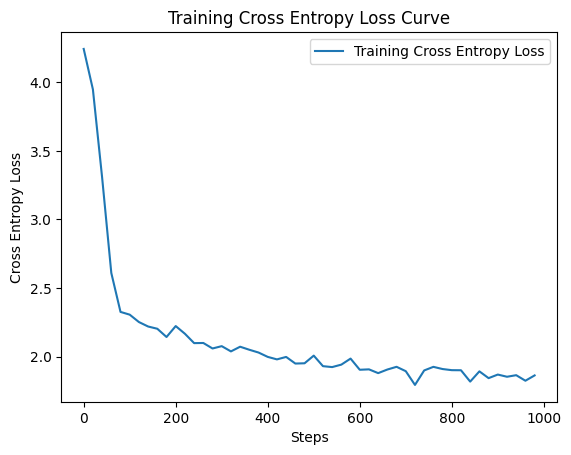

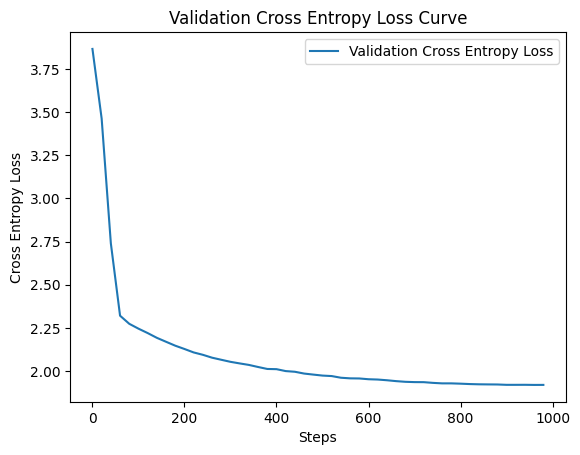

In [31]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

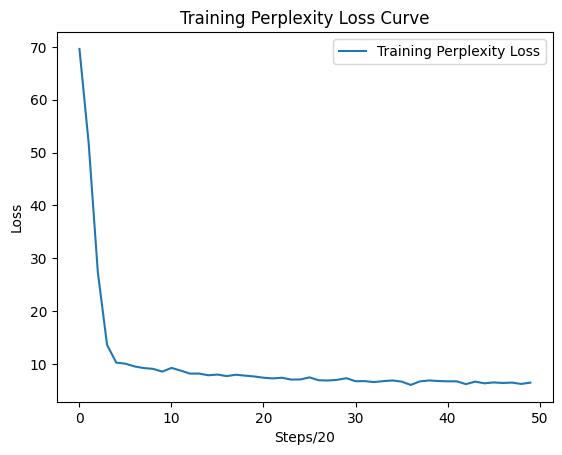

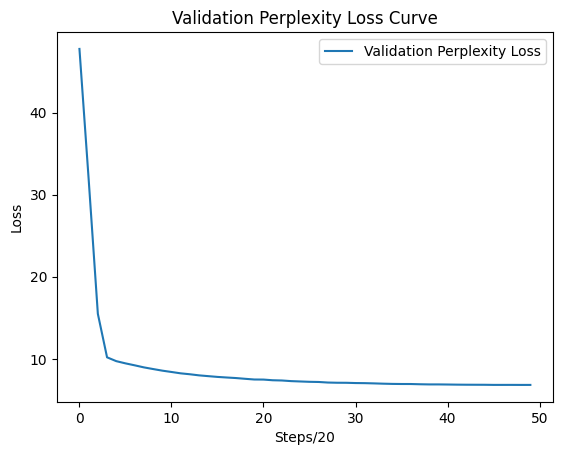

In [32]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()

## **Checkpointed Sampling**

In [33]:
model_250 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-250")

set_seed(40)

device = model_250.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model_250.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?
### Response: I do not see any hint of it. It is probably a matter of mistaken identity. A man was murdered in a bid to gain entry to the house. There are some skeletons on the fence, and the other three are in front of the house. I will take care of all the facts before making any further observations. If anything happens to any of those buried, I will try my utmost to get rid of them. If the culprit is in the house, we shall have


In [34]:
model_500 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-500")

set_seed(40)

device = model_500.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model_500.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?
### Response: No. I don't think so. I believe there was a murderer inside. And I'm certain that I've won a case. In truth, I never knew the name of the policeman or the crime. I just know that he's been the most prominent figure and most respected. And I suppose there was a sense of duty, too. You know that as I see it, my first duty in any courtroom is to protect the victims and to obtain justice for those responsible.


In [35]:
model_750 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-750")

set_seed(40)

device = model_750.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model_750.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house? If so, do you believe this scene was inspired by the murder of Mr. Freeman?"
### Response: A murder by a disgruntled colleague of my own. I suppose the motive was the obvious, perhaps because I'm not the only one who perceives the presence of a vendetta and seeks revenge. That is, of course, a possibility. But I doubt that's the case. Watson is too busy to examine any trace of the house but the stain on the door, and, perhaps,


In [36]:
model_0 = GPT2LMHeadModel.from_pretrained("gpt2")

set_seed(40)

device = model_0.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model_0.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house? A murderer or someone working for Holmes would have done something like this. The question should be how did the murders happen in the first place? I assume that Holmes was not in contact with any of his neighbors when he killed and killed in a small circle around the house.   That does appear to be an inaccurate way to describe Holmes. 
This is the house in question. It looks like a big building that was used to store supplies. There are a number of footprints (I suppose the first
